# Region Proposal Network

what we're doing

We'll start with some imports.

In [1]:
# import numpy as np
import os

import matplotlib
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

from rpn import (
    build_base_network,
    draw_bboxes, open_image, to_image,
)
from resnet import resnet_v1_101

import matplotlib.pyplot as plt

%matplotlib inline

[Image we'll be using to play here onwards.]

In [2]:
# TODO: Do it like this? Or whenever stuff is instanced?
tfe.restore_variables_on_create('checkpoint/rpn').__enter__()

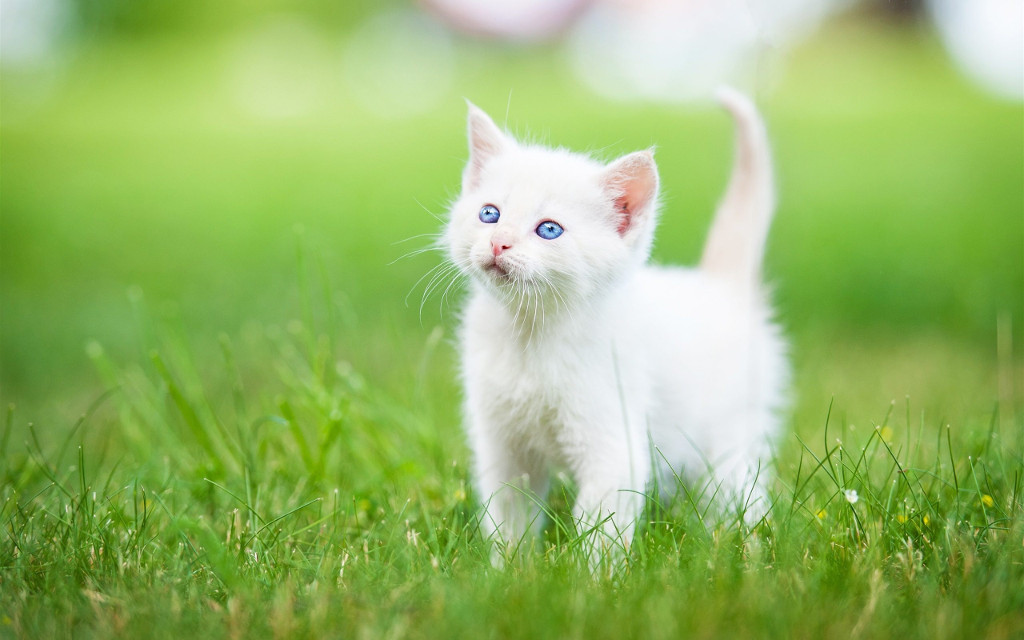

In [3]:
# image = open_image('~/images/cats.png')
image = open_image('~/images/cat.jpg')

to_image(image)

# Base network

The basis for the RPN is leveraging a pre-trained base network to extract feature maps for the image.

We'll be using an already-implemented Resnet.

[play with it]

In [4]:
# TODO: Change to `run_base_network` or something.
feature_map = build_base_network(image)

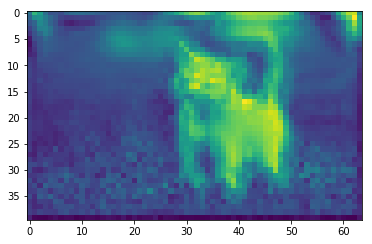

In [5]:
# Pick some feature maps and plot them.
# TODO: Any way to make more significant?
# TODO: Overlay over the image?

plt.imshow(feature_map.numpy()[0, :, :, 1000])

# Generating anchors

[we'll generate anchors for each point in the image, etc]

TODO:
* Mandatory `generate_anchors_reference` or not?

In [6]:
def generate_anchors_reference(base_size, aspect_ratios, scales):
    """Generate base anchor to be used as reference of generating all anchors.

    Anchors vary only in width and height. Using the base_size and the
    different ratios we can calculate the wanted widths and heights.

    Scales apply to area of object.

    Args:
        base_size (int): Base size of the base anchor (square).
        aspect_ratios: Ratios to use to generate different anchors. The ratio
            is the value of height / width.
        scales: Scaling ratios applied to area.

    Returns:
        anchors: Numpy array with shape (total_aspect_ratios * total_scales, 4)
            with the corner points of the reference base anchors using the
            convention (x_min, y_min, x_max, y_max).
    """
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    scales_grid, aspect_ratios_grid = np.meshgrid(scales, aspect_ratios)
    base_scales = scales_grid.reshape(-1)
    base_aspect_ratios = aspect_ratios_grid.reshape(-1)

    aspect_ratio_sqrts = np.sqrt(base_aspect_ratios)
    heights = base_scales * aspect_ratio_sqrts * base_size
    widths = base_scales / aspect_ratio_sqrts * base_size

    # Center point has the same X, Y value.
    center_xy = 0

    # Create anchor reference.
    anchors = np.column_stack([
        center_xy - (widths - 1) / 2,
        center_xy - (heights - 1) / 2,
        center_xy + (widths - 1) / 2,
        center_xy + (heights - 1) / 2,
    ])

    real_heights = (anchors[:, 3] - anchors[:, 1]).astype(np.int)
    real_widths = (anchors[:, 2] - anchors[:, 0]).astype(np.int)

    ####
    
    return anchors


references = generate_anchors_reference(
    256,  # Base size.
    [0.5, 1, 2],  # Aspect ratios.
    [0.5, 1, 2],  # Scales.
)

print('Anchor references (real image size):')
print()
print(references)

Anchor references (real image size):

[[ -90.00966799  -44.754834     90.00966799   44.754834  ]
 [-180.51933598  -90.00966799  180.51933598   90.00966799]
 [-361.53867197 -180.51933598  361.53867197  180.51933598]
 [ -63.5         -63.5          63.5          63.5       ]
 [-127.5        -127.5         127.5         127.5       ]
 [-255.5        -255.5         255.5         255.5       ]
 [ -44.754834    -90.00966799   44.754834     90.00966799]
 [ -90.00966799 -180.51933598   90.00966799  180.51933598]
 [-180.51933598 -361.53867197  180.51933598  361.53867197]]


Figures plotted:


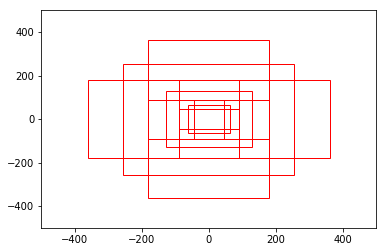

In [7]:
print('Figures plotted:')

fig, ax = plt.subplots(1)

for ref_idx in range(references.shape[0]):
    x_min, y_min, x_max, y_max = references[ref_idx, :]
    rect = matplotlib.patches.Rectangle(
        (x_min, -y_max),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    
    ax.set_xlim([-500, 500])
    ax.set_ylim([-500, 500])

plt.show()

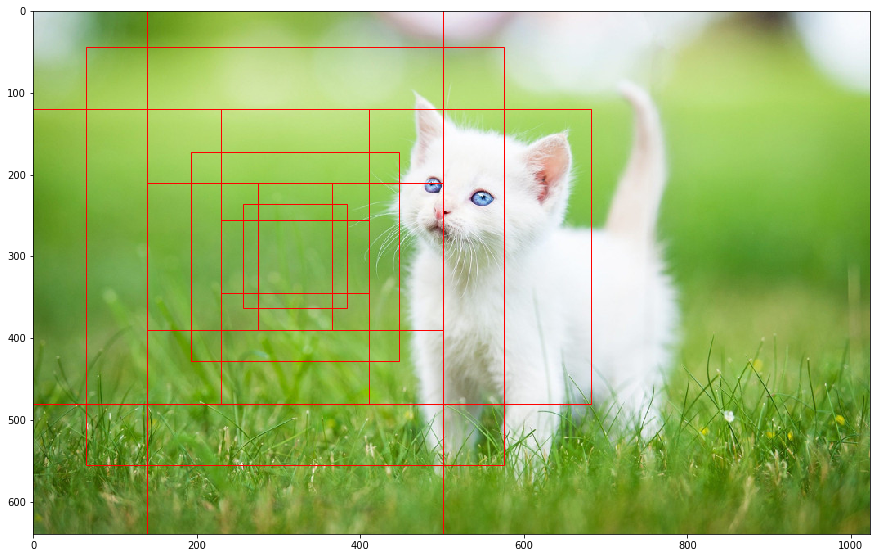

In [8]:
# TODO: Fix/clarify y-coordinate issues.
point = np.array([320, -300])

p_min, p_max = references[:, :2], references[:, 2:]

p_references = np.concatenate([point + p_min, point + p_max], axis=1)

fig, ax = plt.subplots(1, figsize=(15, 20))

ax.imshow(to_image(image))

for ref_idx in range(p_references.shape[0]):
    x_min, y_min, x_max, y_max = p_references[ref_idx, :]
    rect = matplotlib.patches.Rectangle(
        (x_min, -y_max),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()

In [9]:
# TODO: Document.
ANCHOR_BASE_SIZE = 256
ANCHOR_RATIOS = [0.5, 1, 2]
ANCHOR_SCALES = [0.125, 0.25, 0.5, 1, 2]

OUTPUT_STRIDE = 16


def generate_anchors(feature_map_shape):
    """Generate anchors for an image.

    Using the feature map (the output of the pretrained network for an image)
    and the anchor references (generated using the specified anchor sizes and
    ratios), we generate a list of anchors.

    Anchors are just fixed bounding boxes of different ratios and sizes that
    are uniformly generated throught the image.

    Args:
        feature_map_shape: Shape of the convolutional feature map used as
            input for the RPN. Should be (batch, height, width, depth).

    Returns:
        all_anchors: A flattened Tensor with all the anchors of shape
            `(num_anchors_per_points * feature_width * feature_height, 4)`
            using the (x1, y1, x2, y2) convention.
    """

    anchor_reference = generate_anchors_reference(
        ANCHOR_BASE_SIZE, ANCHOR_RATIOS, ANCHOR_SCALES
    )
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    with tf.variable_scope('generate_anchors'):
        grid_width = feature_map_shape[2]  # width
        grid_height = feature_map_shape[1]  # height
        shift_x = tf.range(grid_width) * OUTPUT_STRIDE
        shift_y = tf.range(grid_height) * OUTPUT_STRIDE
        shift_x, shift_y = tf.meshgrid(shift_x, shift_y)

        shift_x = tf.reshape(shift_x, [-1])
        shift_y = tf.reshape(shift_y, [-1])

        shifts = tf.stack(
            [shift_x, shift_y, shift_x, shift_y],
            axis=0
        )

        shifts = tf.transpose(shifts)
        # Shifts now is a (H x W, 4) Tensor

        # Expand dims to use broadcasting sum.
        all_anchors = (
            np.expand_dims(anchor_reference, axis=0) +
            tf.expand_dims(shifts, axis=1)
        )

        # Flatten
        all_anchors = tf.reshape(
            all_anchors, (-1, 4)
        )
    
    ####

    return all_anchors

anchors = generate_anchors(feature_map.shape)

print('Anchors ([real] image size):')
print()
print(anchors.numpy())

# TODO: Draw. (Same visualization than in the slides?)

Anchors ([real] image size):

[[ -22  -10   22   10]
 [ -44  -22   44   22]
 [ -90  -44   90   44]
 ...
 [ 964  534 1052  714]
 [ 918  444 1098  804]
 [ 828  263 1188  985]]


---
# Encoding and decoding coordinates

Faster R-CNN uses a special encoding [etc].

In [10]:
def encode(bboxes, gt_boxes):
    with tf.name_scope('BoundingBoxTransform/encode'):
        
        ####
        # Fill this function below, paying attention to the docstring.
        ####
        
        (
            bboxes_width, bboxes_height, bboxes_urx, bboxes_ury
        ) = get_width_upright(bboxes)

        (
            gt_boxes_width, gt_boxes_height, gt_boxes_urx, gt_boxes_ury
        ) = get_width_upright(gt_boxes)

        targets_dx = (gt_boxes_urx - bboxes_urx) / bboxes_width
        targets_dy = (gt_boxes_ury - bboxes_ury) / bboxes_height

        targets_dw = tf.log(gt_boxes_width / bboxes_width)
        targets_dh = tf.log(gt_boxes_height / bboxes_height)

        targets = tf.concat([
            targets_dx, targets_dy, targets_dw, targets_dh
        ], axis=1)
        
        ####

        return targets
    
    
# Test encoding.

In [11]:
def get_width_upright(bboxes):
    """
    TODO: Docstring.
    """
    with tf.name_scope('BoundingBoxTransform/get_width_upright'):
        bboxes = tf.cast(bboxes, tf.float32)
        x1, y1, x2, y2 = tf.split(bboxes, 4, axis=1)
        width = x2 - x1 + 1.
        height = y2 - y1 + 1.

        # Calculate up right point of bbox (urx = up right x)
        urx = x1 + .5 * width
        ury = y1 + .5 * height

        return width, height, urx, ury



def decode(roi, deltas):
    """
    TODO: Docstring plus param name change.
    """
    with tf.name_scope('BoundingBoxTransform/decode'):
        
        ####
        # Fill this function below, paying attention to the docstring.
        ####
        
        (
            roi_width, roi_height, roi_urx, roi_ury
        ) = get_width_upright(roi)

        dx, dy, dw, dh = tf.split(deltas, 4, axis=1)

        pred_ur_x = dx * roi_width + roi_urx
        pred_ur_y = dy * roi_height + roi_ury
        pred_w = tf.exp(dw) * roi_width
        pred_h = tf.exp(dh) * roi_height

        bbox_x1 = pred_ur_x - 0.5 * pred_w
        bbox_y1 = pred_ur_y - 0.5 * pred_h

        # This -1. extra is different from reference implementation.
        # TODO: What does this do?
        bbox_x2 = pred_ur_x + 0.5 * pred_w - 1.
        bbox_y2 = pred_ur_y + 0.5 * pred_h - 1.

        bboxes = tf.concat([
            bbox_x1, bbox_y1, bbox_x2, bbox_y2
        ], axis=1)
        
        ####

        return bboxes
    
    
# Test decoding.

In [12]:
# Test roundtrip.

---

# RPN layers

RPN uses convs, etc. This predicts the encoded deltas.

In [13]:
def build_rpn(feature_map):
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    rpn_conv = tf.layers.conv2d(
        feature_map,
        filters=512,
        kernel_size=[3, 3],
        activation=tf.nn.relu6,
        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        kernel_regularizer=tf.contrib.layers.l2_regularizer(0.0005),
        padding='same',
        name='rpn/conv',
    )

    num_anchors = len(ANCHOR_RATIOS) * len(ANCHOR_SCALES)
    rpn_cls = tf.layers.conv2d(
        rpn_conv,
        filters=num_anchors * 2,
        kernel_size=[1, 1],
        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        kernel_regularizer=tf.contrib.layers.l2_regularizer(0.0005),
        name='rpn/cls_conv',
    )
    rpn_cls_score = tf.reshape(rpn_cls, [-1, 2])
    rpn_cls_prob = tf.nn.softmax(rpn_cls_score)

    rpn_bbox = tf.layers.conv2d(
        rpn_conv,
        filters=num_anchors * 4,
        kernel_size=[1, 1],
        kernel_initializer=(
            tf.random_normal_initializer(mean=0.0, stddev=0.001)
        ),
        kernel_regularizer=tf.contrib.layers.l2_regularizer(0.0005),
        name='rpn/bbox_conv',
    )
    rpn_bbox_pred = tf.reshape(rpn_bbox, [-1, 4])
    
    ####

    return rpn_bbox_pred, rpn_cls_prob


rpn_bbox_pred, rpn_cls_prob = build_rpn(feature_map)

# Generating and filtering proposals

We have the output, now let's do something with it.

In [14]:
# Generate proposals from the RPN's output by decoding the bounding boxes
# according to the configured anchors.
proposals = decode(anchors, rpn_bbox_pred)

# Get the (positive-object) scores from the RPN.
# TODO: Could be just one dimension, right? (If not for compatibility.)
scores = tf.reshape(rpn_cls_prob[:, 1], [-1])

In [15]:
# Filter proposals, keeping only valid bboxes.


def filter_proposals(proposals, scores):
    """Filters zero-area proposals."""
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    (x_min, y_min, x_max, y_max) = tf.unstack(proposals, axis=1)
    zero_area_filter = tf.greater(
        tf.maximum(x_max - x_min, 0.0) * tf.maximum(y_max - y_min, 0.0),
        0.0
    )
    proposal_filter = zero_area_filter

    scores = tf.boolean_mask(
        scores, proposal_filter,
        name='filtered_scores'
    )
    proposals = tf.boolean_mask(
        proposals, proposal_filter,
        name='filtered_proposals'
    )
    
    ####

    return proposals, scores


# Filter proposals with negative areas.
proposals, scores = filter_proposals(proposals, scores)

In [16]:
PRE_NMS_TOP_N = 12000
POST_NMS_TOP_N = 2000
NMS_THRESHOLD = 0.7


# Reduce the number of proposals by applying non-maximum suppression to proposals.


def change_order(bboxes):
    """Change bounding box encoding order.

    TensorFlow works with the (y_min, x_min, y_max, x_max) order while we work
    with the (x_min, y_min, x_max, y_min).

    While both encoding options have its advantages and disadvantages we
    decided to use the (x_min, y_min, x_max, y_min), forcing use to switch to
    TensorFlow's every time we want to use a std function that handles bounding
    boxes.

    Args:
        bboxes: A Tensor of shape (total_bboxes, 4)

    Returns:
        bboxes: A Tensor of shape (total_bboxes, 4) with the order swaped.
    """
    with tf.name_scope('BoundingBoxTransform/change_order'):
        first_min, second_min, first_max, second_max = tf.unstack(
            bboxes, axis=1
        )
        bboxes = tf.stack(
            [second_min, first_min, second_max, first_max], axis=1
        )
        return bboxes
    

def apply_nms(proposals, scores):
    """Applies non-maximum suppression to proposals."""
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    # Get top `pre_nms_top_n` indices by sorting the proposals by score.
    # Sorting is done to reduce the number of proposals to run NMS in, and also
    # to return proposals ordered by score.
    k = tf.minimum(PRE_NMS_TOP_N, tf.shape(scores)[0])
    top_k = tf.nn.top_k(scores, k=k)

    sorted_top_proposals = tf.gather(proposals, top_k.indices)
    sorted_top_scores = top_k.values

    with tf.name_scope('nms'):
        # We reorder the proposals into TensorFlows bounding box order
        # for `tf.image.non_max_suppression` compatibility.
        proposals_tf_order = change_order(sorted_top_proposals)
        # We cut the pre_nms filter in pure TF version and go straight
        # into NMS.
        selected_indices = tf.image.non_max_suppression(
            proposals_tf_order, tf.reshape(
                sorted_top_scores, [-1]
            ),
            POST_NMS_TOP_N, iou_threshold=NMS_THRESHOLD
        )

        # Selected_indices is a smaller tensor, we need to extract the
        # proposals and scores using it.
        nms_proposals_tf_order = tf.gather(
            proposals_tf_order, selected_indices,
            name='gather_nms_proposals'
        )

        # We switch back again to the regular bbox encoding.
        proposals = change_order(nms_proposals_tf_order)
        scores = tf.gather(
            sorted_top_scores, selected_indices,
            name='gather_nms_proposals_scores'
        )
        
    ####

    return proposals, scores


proposals, scores = apply_nms(proposals, scores)

---
# Run it!

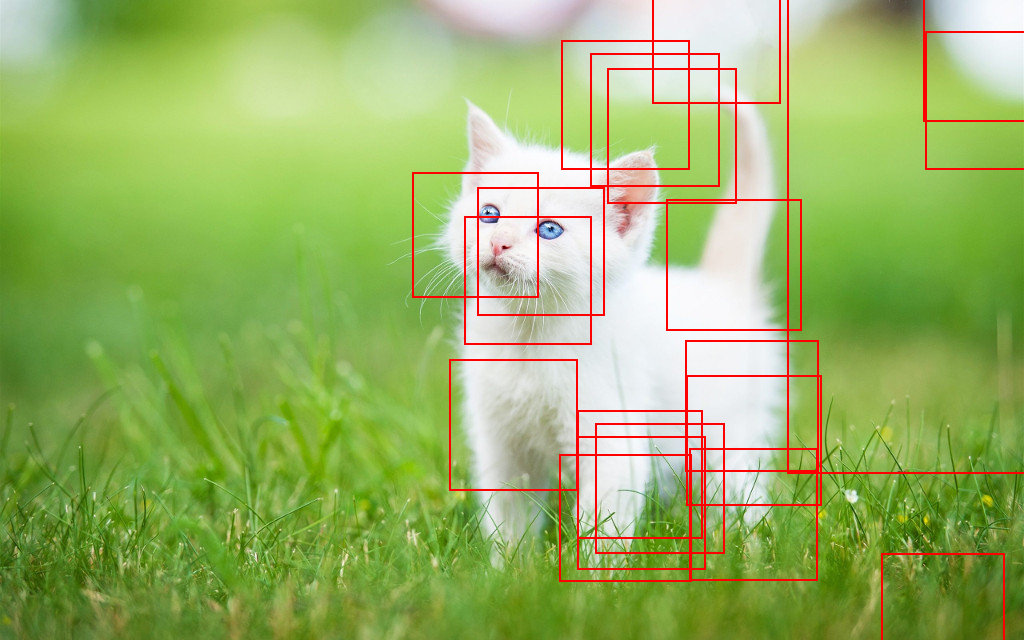

In [20]:
# TODO: Why is it not returning the same? All sizes equal.
draw_bboxes(image, proposals[:20])